##### Отправляем сообщения всегда, но узел может быть не активен (блокирован) тогда сообщение ставится в очередь на узел
##### после блокировки узел считается снова свободным если очередь < L
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 3.54
MultiplierThresholdToBlock <strong>L 100</strong>, FractionThresholdToUnBlock 1, UseOnlyIsActiveNodes True, NumberOfGenerations 150 <br>


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result\\12.01 300 Nodes"
numberOfGenerations = 150;
percolation = 0.69;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    #{"filename": "Netsim-Connection-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на связи"},
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
    {"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
        #labelLines(plt.gca().get_lines(), zorder=2.5)
        #lines = plt.gca().get_lines();
        #print(len(lines))
        #xvals = get_xvals(lines)
        #for idx in range(len(lines)-1):
        #    labelLine(lines[idx+1], get_x(xvals, idx, len(lines)-1), label=str(idx+1), fontsize=14, align=False)
                                   
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()


def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%d.%m.%Y %H:%M:%S\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

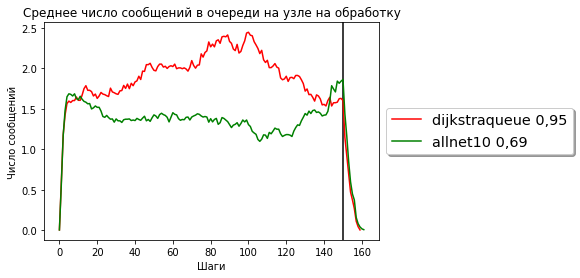

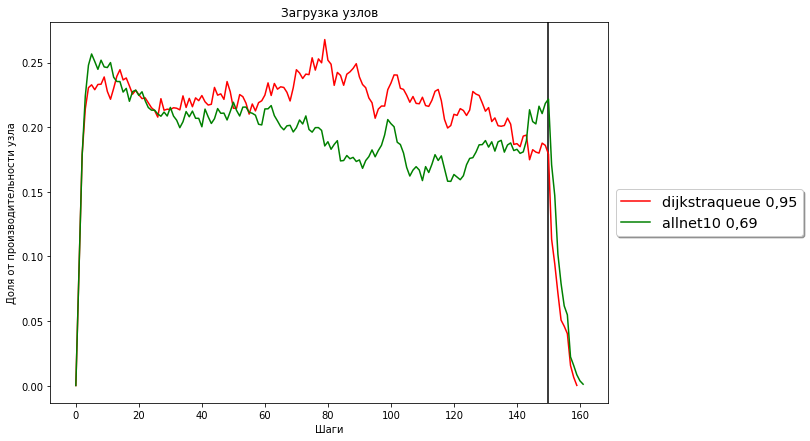

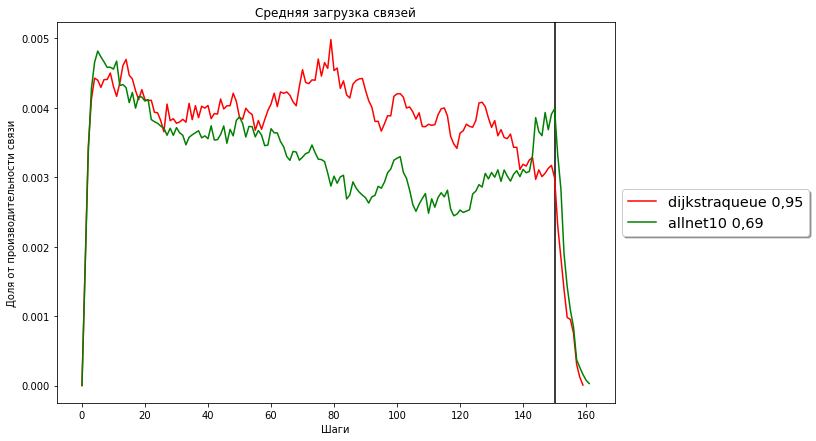

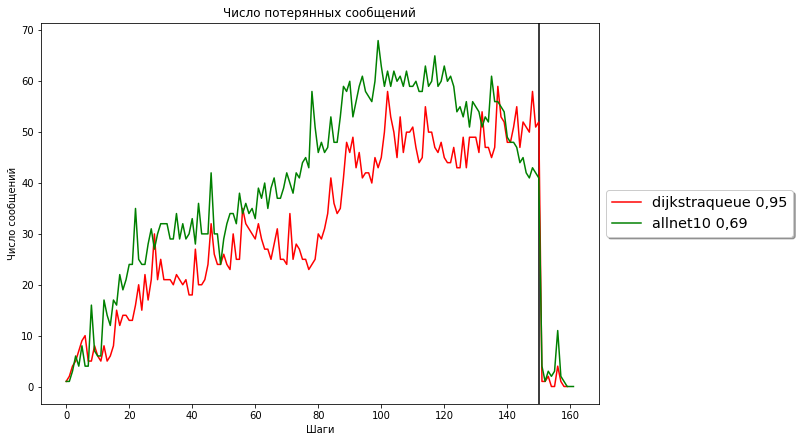

Доставлено 10093 Потеряно 32.7178% -dijkstraqueue 0,95
Доставлено 8812 Потеряно 41.2572% -allnet10 0,69


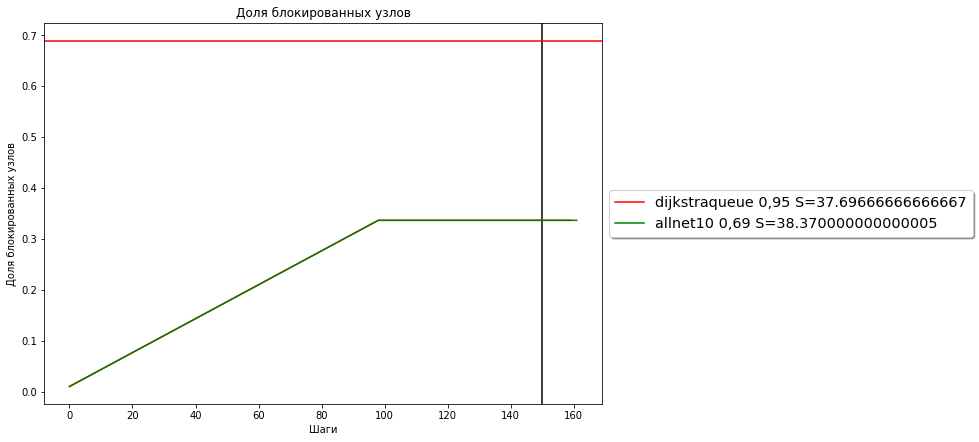

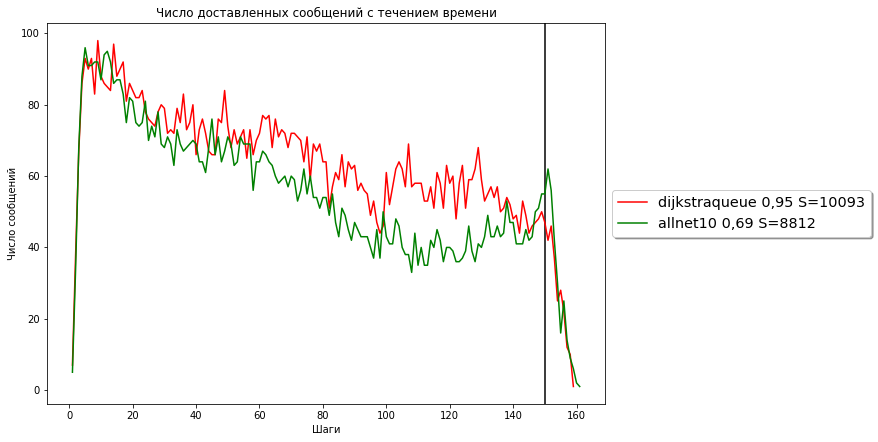

In [2]:
quantity = 100;
log_tags = [
{"tag":  "c70b036a-b75d-4308-b3e5-17a2d9faf5c1", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "c801b355-774f-4d9d-bf54-ea804ce6aaf9", "label": "allnet10 0,69", "color": "green"},
]
                             
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 500 </strong>

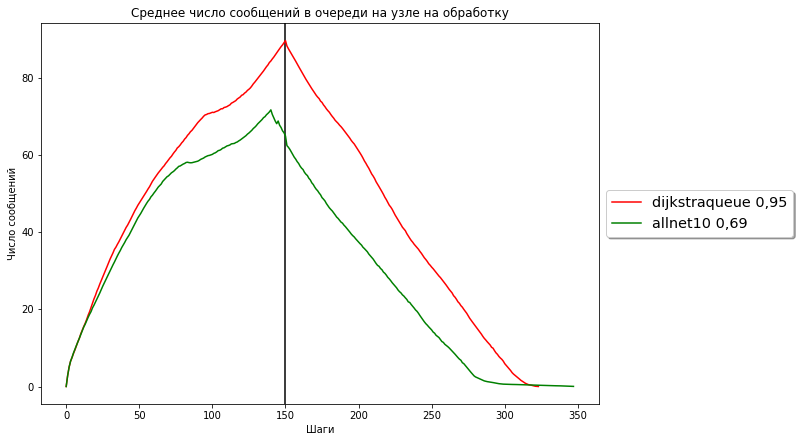

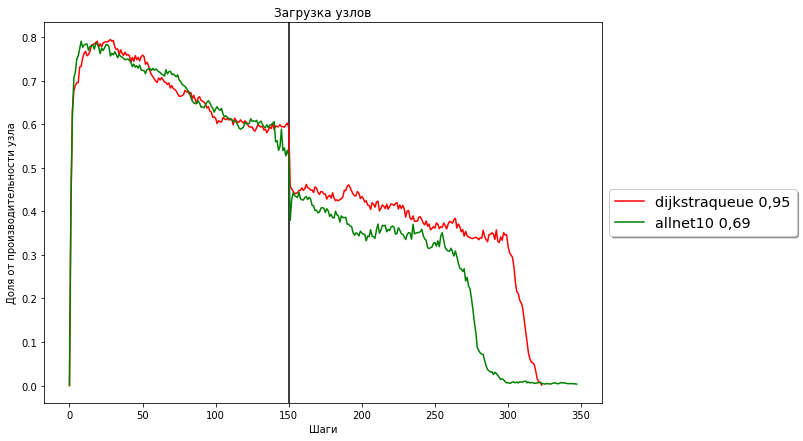

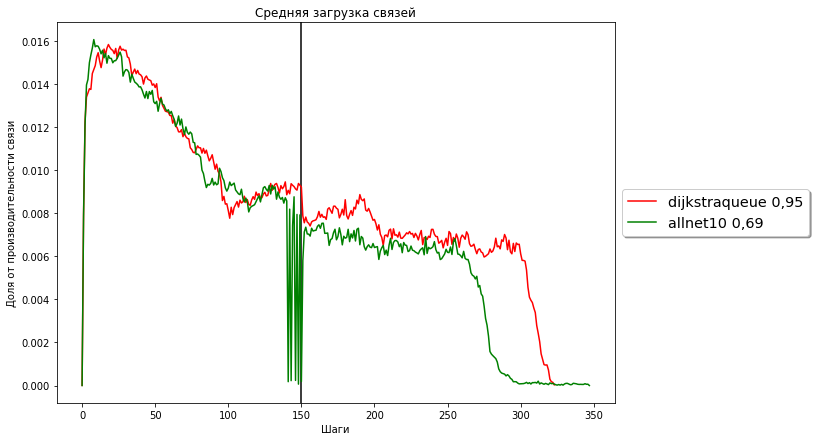

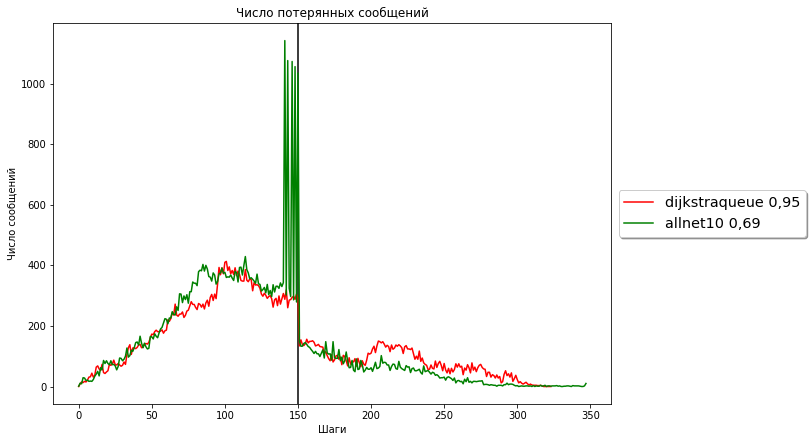

Доставлено 28516 Потеряно 61.9792% -dijkstraqueue 0,95
Доставлено 26636 Потеряно 64.4858% -allnet10 0,69


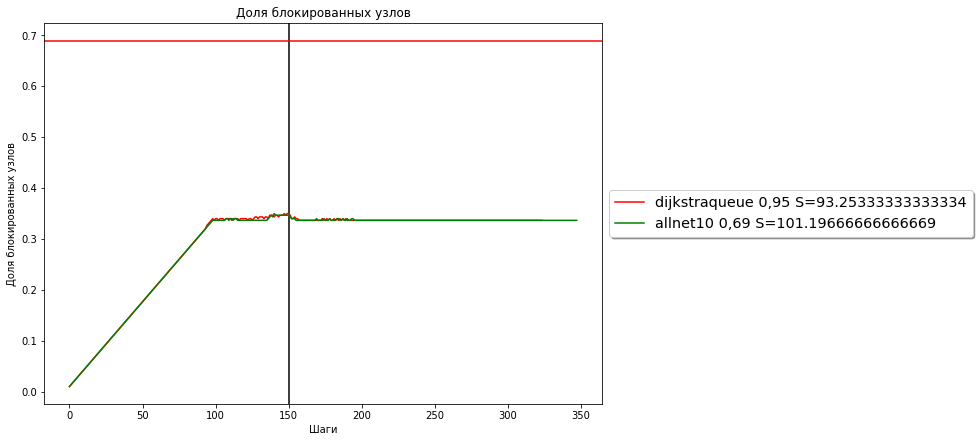

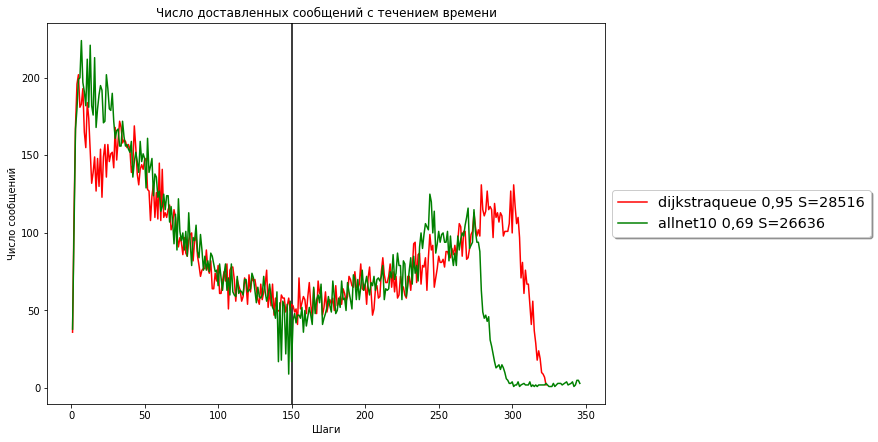

In [3]:
quantity = 500;
log_tags = [
{"tag":  "7f9fcf69-97f2-4262-a837-1e4c68a5108b", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "975742c5-a1b3-4f49-a6c4-549519746522", "label": "allnet10 0,69", "color": "green"},
]
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

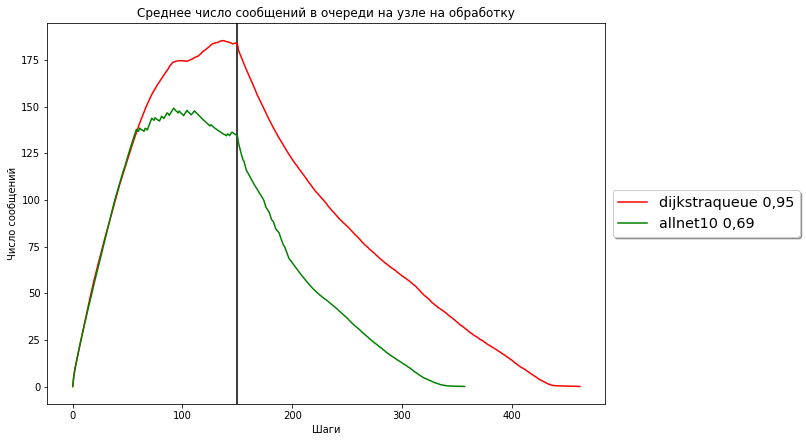

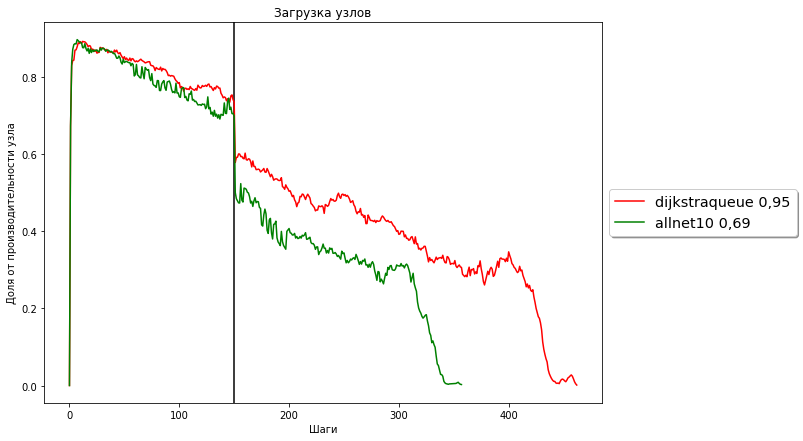

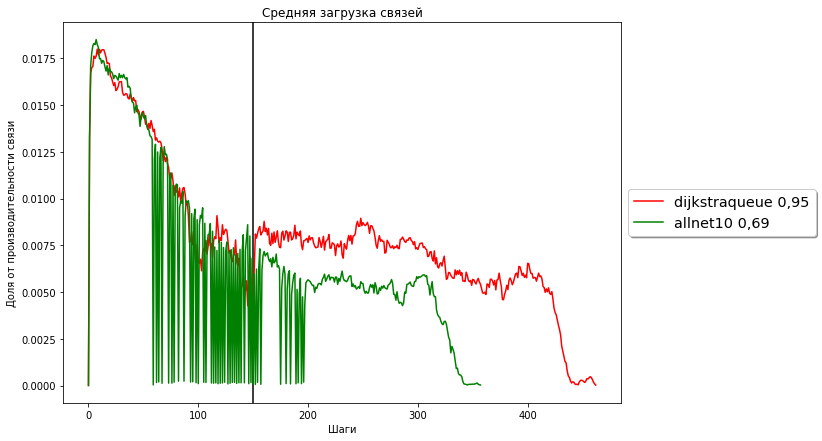

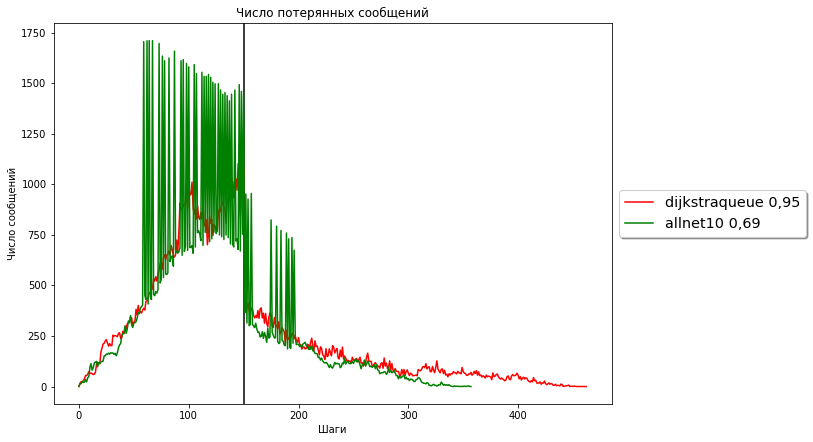

Доставлено 29486 Потеряно 80.3428% -dijkstraqueue 0,95
Доставлено 19911 Потеряно 86.7261% -allnet10 0,69


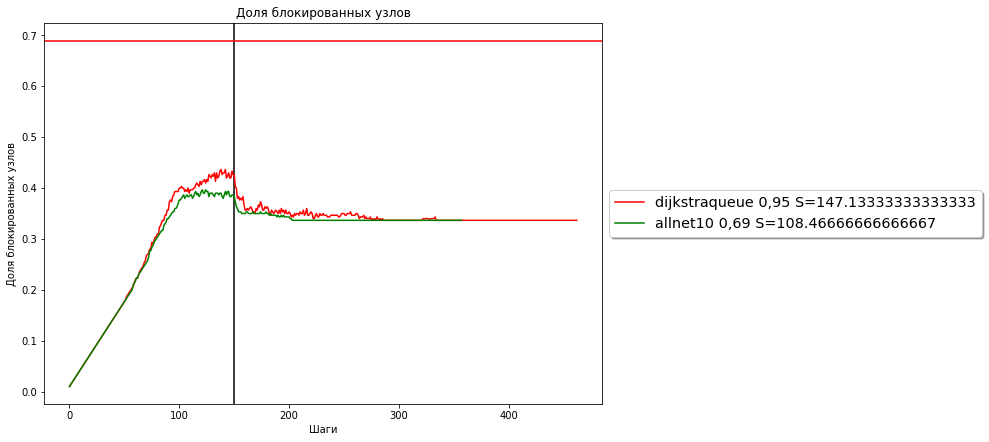

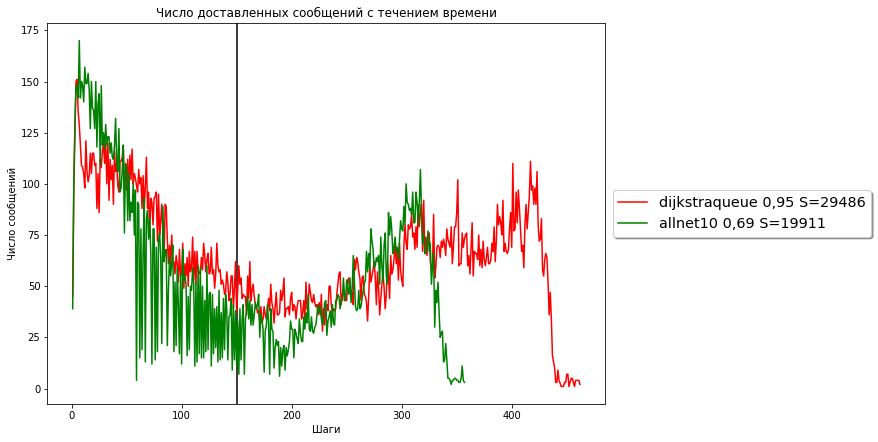

In [4]:
quantity = 1000;
log_tags = [
{"tag":  "78f319c1-ee86-405b-b0d0-c9d7cae433c9", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "f7f7349a-e303-47a6-abb5-c878c962f2ed", "label": "allnet10 0,69", "color": "green"},
]
showStat()
showStatBlocked();  
showStatMessage();

<strong>Quantity 1500 </strong>

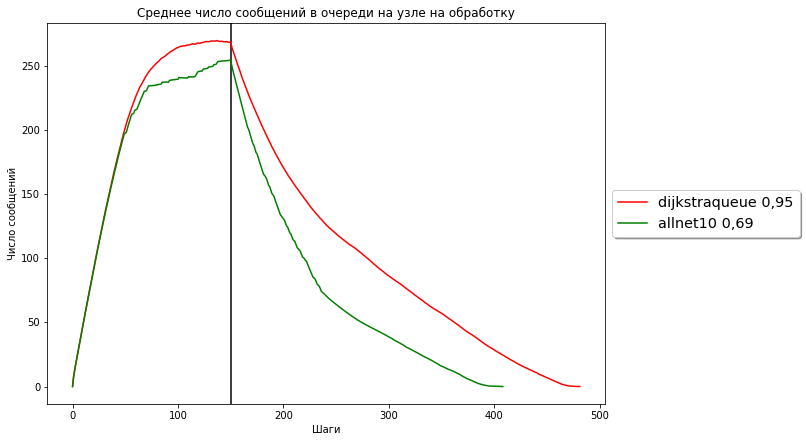

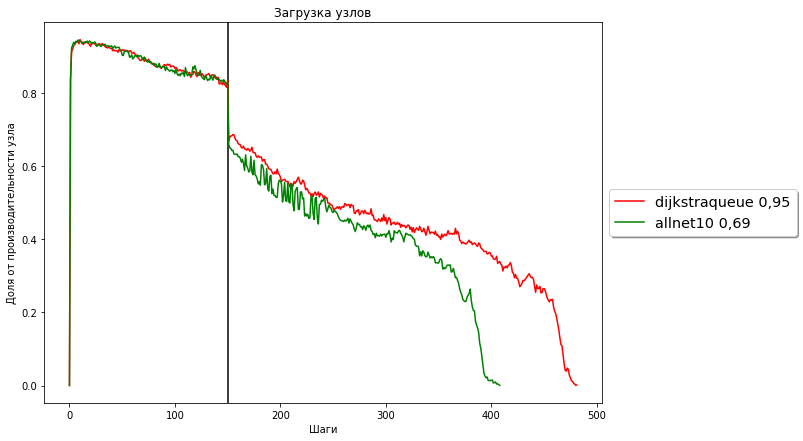

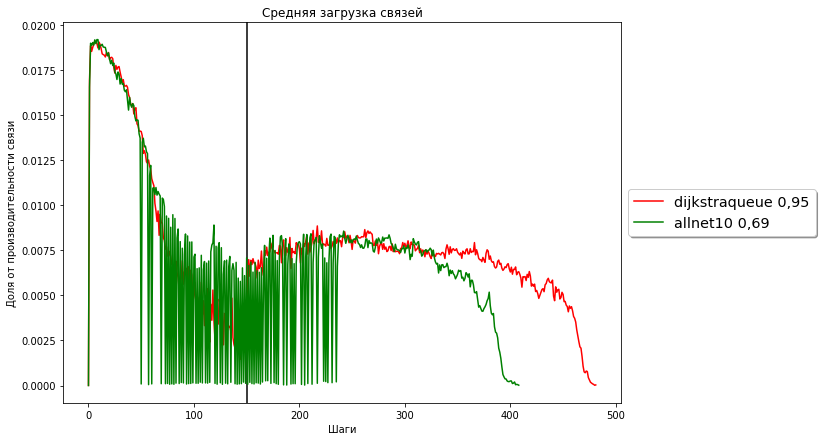

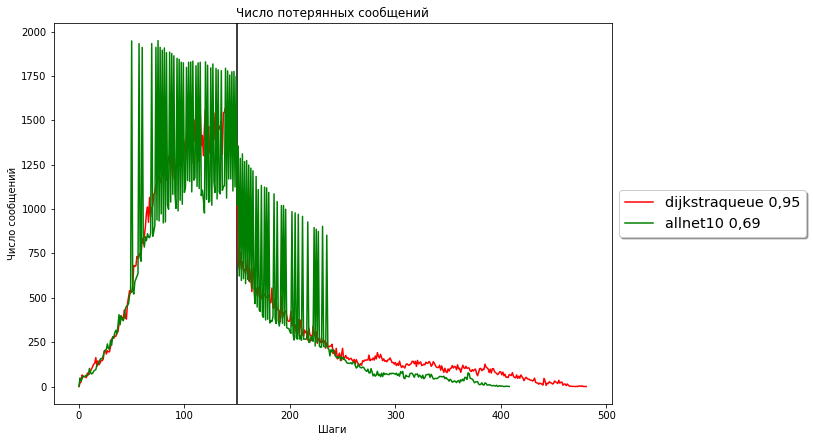

Доставлено 28117 Потеряно 87.5036% -dijkstraqueue 0,95
Доставлено 20930 Потеряно 90.6978% -allnet10 0,69


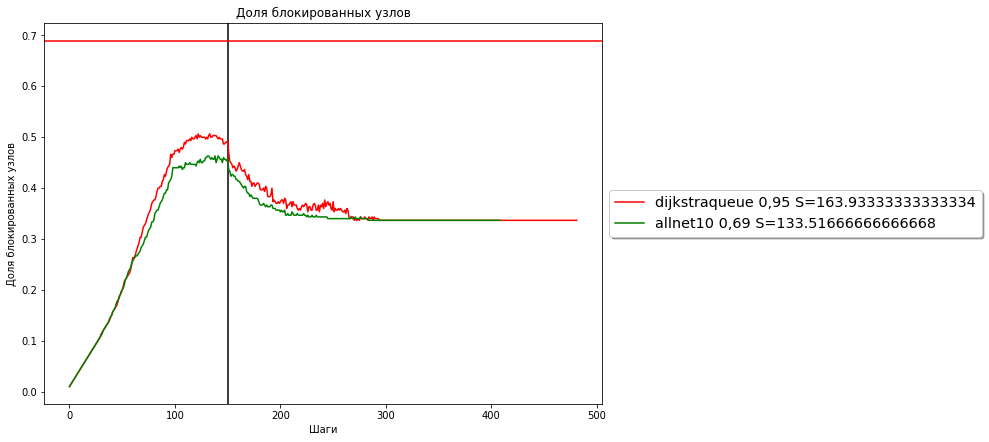

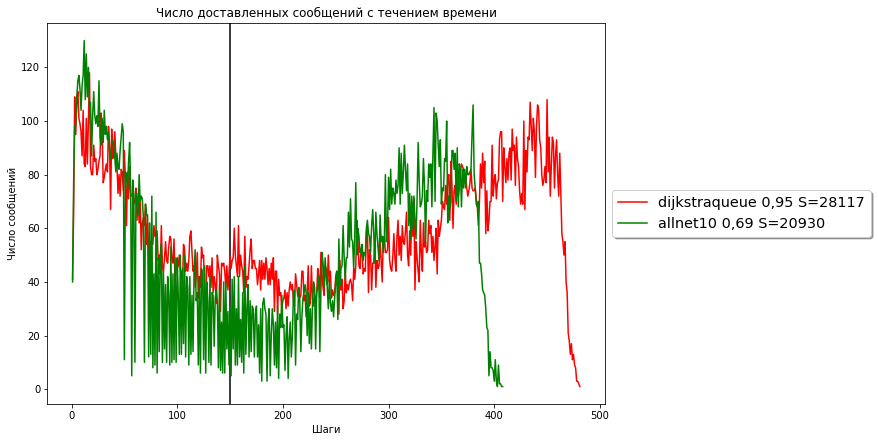

In [5]:
quantity = 1500;
log_tags = [
{"tag":  "9854b0fe-c100-475c-82b6-de1228b343b3", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "5cec9668-6482-40a4-bc5a-16ddb82fddcd", "label": "allnet10 0,69", "color": "green"},
]
showStat()
showStatBlocked();  
showStatMessage();

Доставлено 23974 Потеряно 46.7256% -dijkstraqueue 0,95
Доставлено 25021 Потеряно 44.3990% -allnet10 0,69


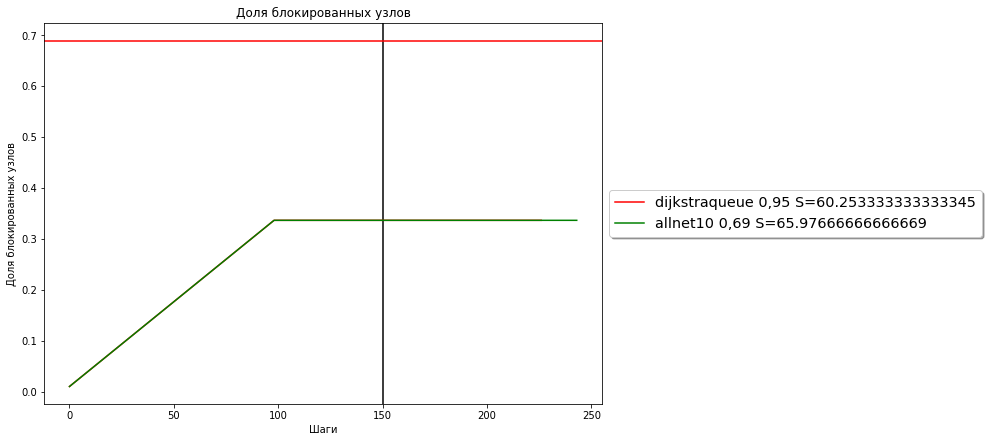

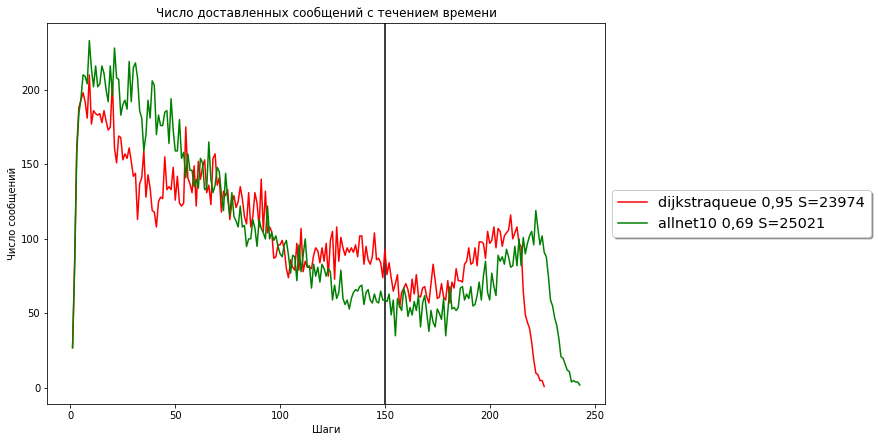

Доставлено 31028 Потеряно 70.4498% -dijkstraqueue 0,95
Доставлено 26609 Потеряно 74.6583% -allnet10 0,69


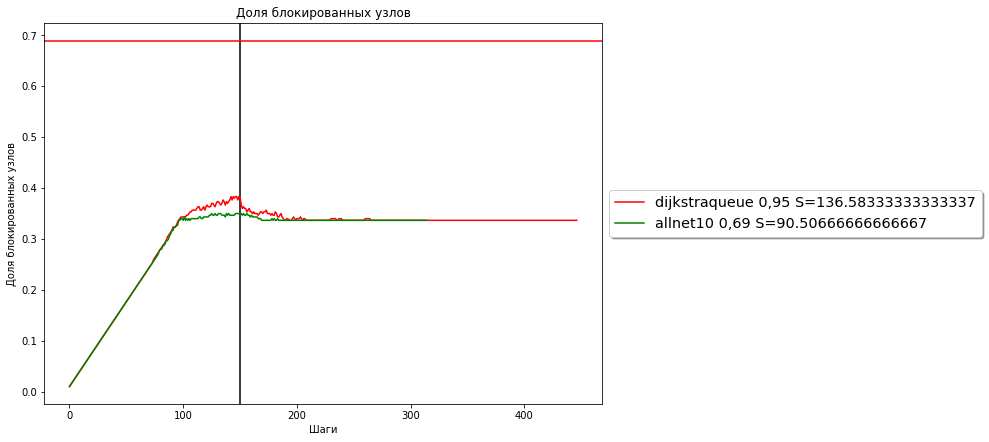

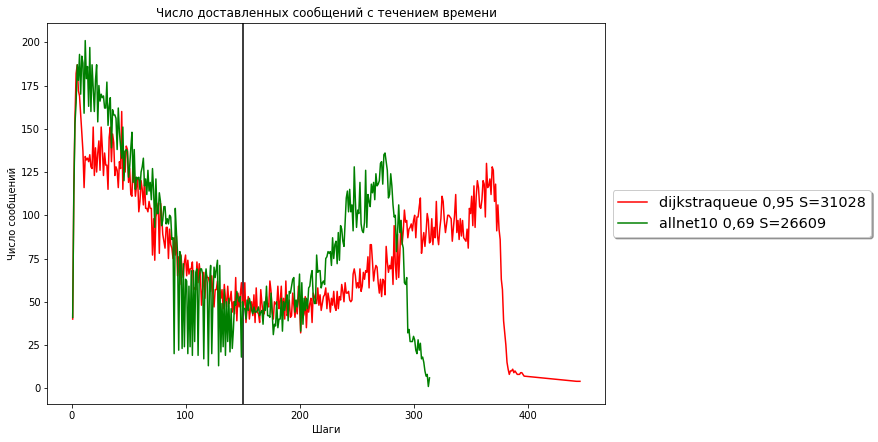

Доставлено 30357 Потеряно 77.5135% -dijkstraqueue 0,95
Доставлено 23005 Потеряно 82.9594% -allnet10 0,69


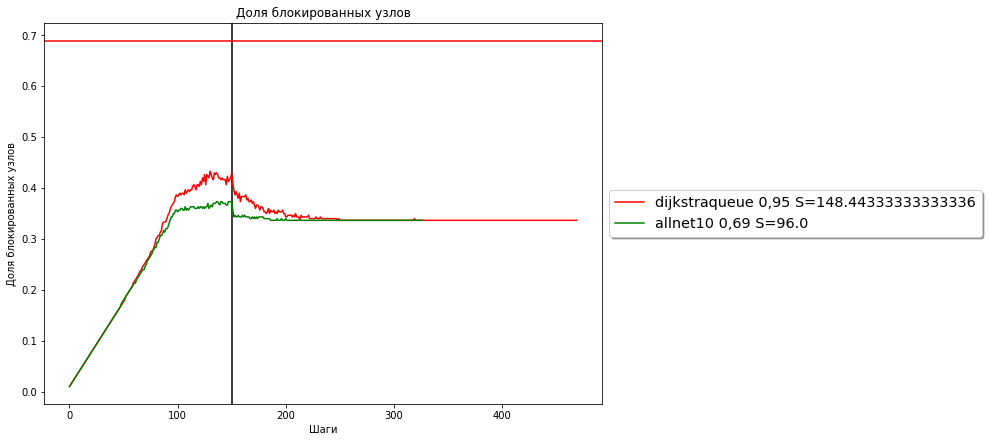

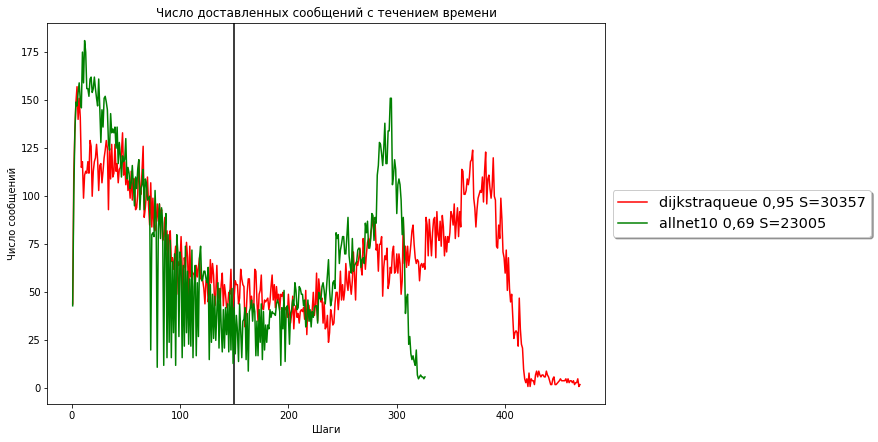

Доставлено 30271 Потеряно 84.4765% -dijkstraqueue 0,95
Доставлено 22938 Потеряно 88.2370% -allnet10 0,69


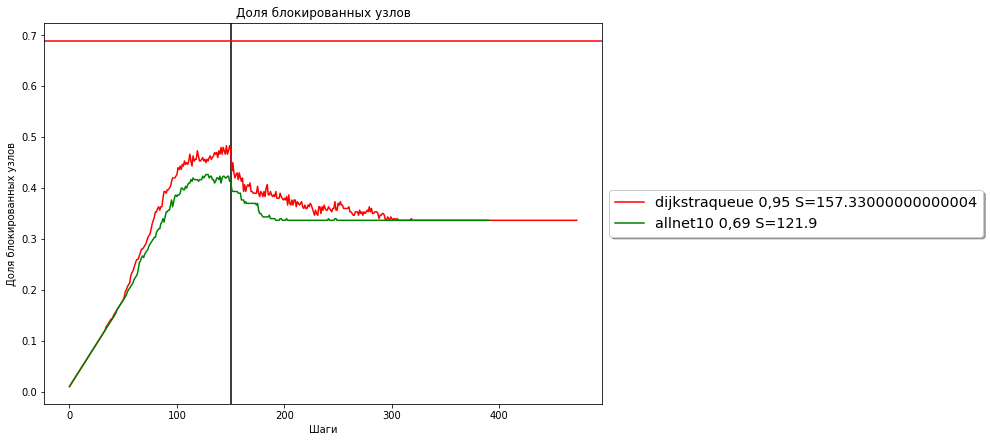

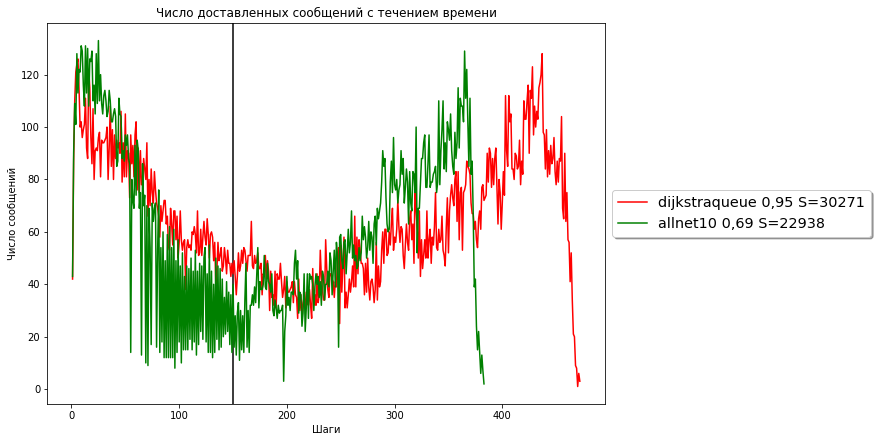

In [6]:
quantity = 300;
log_tags = [
{"tag":  "7c0bd8cd-e328-4c10-bbe8-21a5ff710499", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "c4f7ddc3-ffcf-496a-bd34-56f1b3f9baf9", "label": "allnet10 0,69", "color": "green"},
]
showStatBlocked();
showStatMessage();

quantity = 700;
log_tags = [
{"tag":  "c89aa31c-4d15-4c6b-a820-7c487d460fd4", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "674d2610-cb10-483a-8a70-04d2b1ff7b8a", "label": "allnet10 0,69", "color": "green"},
]
showStatBlocked();
showStatMessage();

quantity = 900;
log_tags = [
{"tag":  "61f7f661-740b-460e-b958-27d918669c76", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "b1d112a0-76d3-4f16-8a66-4a1b616e5582", "label": "allnet10 0,69", "color": "green"},
]
showStatBlocked();
showStatMessage();

quantity = 1300;
log_tags = [
{"tag":  "f762bec0-14c2-4023-a27c-83c19f63c3d2", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "ebdde4c3-3f3f-43ba-afbb-722a5aa9868c", "label": "allnet10 0,69", "color": "green"},
]
showStatBlocked();
showStatMessage();

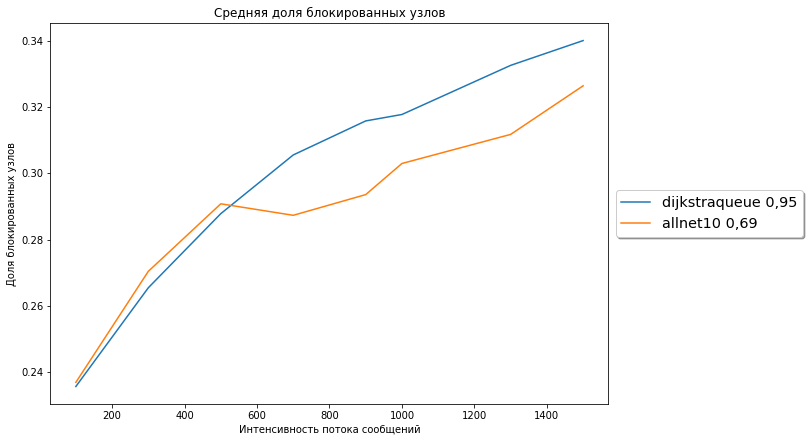

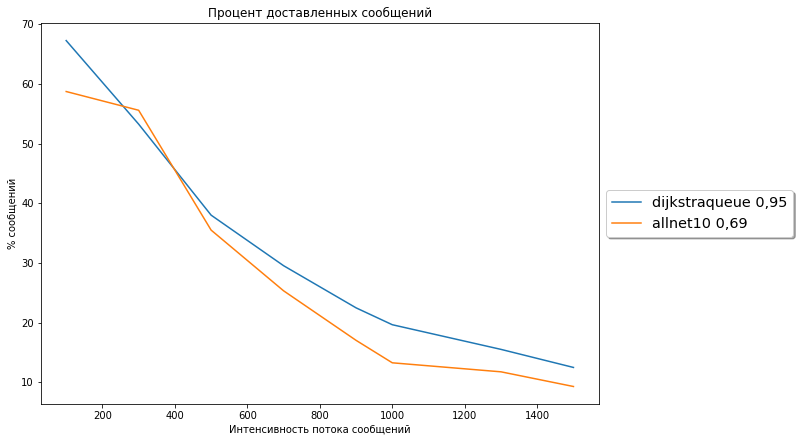

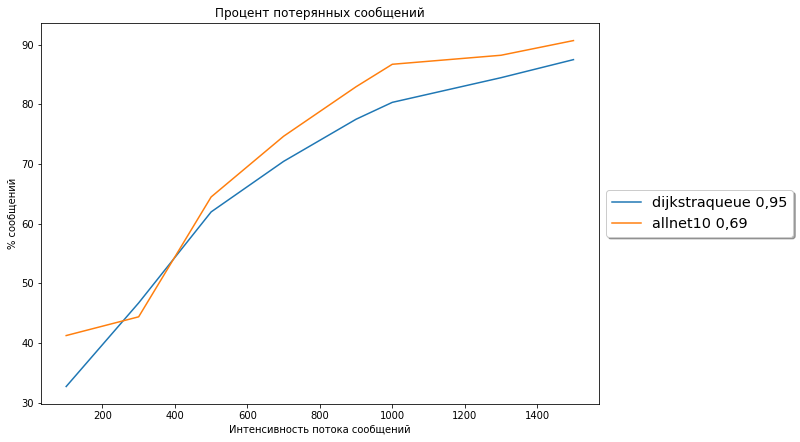

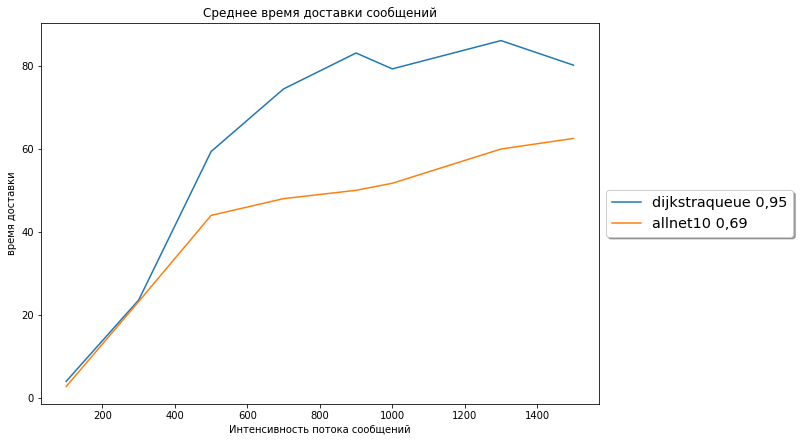

In [7]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageResived.sort_index(inplace=True)
axs = MessageResived.plot()
axs.set_title("Процент доставленных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageFall.sort_index(inplace=True)
axs = MessageFall.plot()
axs.set_title("Процент потерянных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()


In [8]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())

dijkstraqueue 0,95    0.300095
allnet10 0,69         0.290017

dijkstraqueue 0,95    67.713603
allnet10 0,69         71.677585

dijkstraqueue 0,95    61.203812
allnet10 0,69         42.746909
